## Entrenamiento automático para caso Telecom

Después de haber realizado un análisis exploratorio de los datos y observar el comportamiento de diferentes características con la característica objetivo, se procede a realizar el entrenamiento.  
Como primer paso se importan todas las librerías necesarias para preparación de datos, entrenamiento, evaluación y visualización de los resultados.

In [207]:
# Librerías de manipulación de datos
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para procesamiento de datos orientado a ML
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder

# Librerías de ML y evaluación
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Módulos para evaluación de modelos 
import sklearn.metrics as metrics
from sklearn.model_selection import cross_validate

Primero cargamos las versión condensada de los datos y corregimos el formato de fecha para poder utilizar como característica, corregimos el tipo de valor del total de los cargos, se muestra la estructura de nuestro dataframe y una muestra de 5 valores aleatorios.

In [208]:
# Carga del archivo condensado y asignación de tipo datetime a las columnas con fechas
condensado = pd.read_csv('Condensado_final.csv')
condensado['EndDate'] = pd.to_datetime(condensado['EndDate'], errors="coerce")
condensado['BeginDate'] = pd.to_datetime(condensado['BeginDate'])
condensado['TotalCharges'] = condensado['TotalCharges'].replace(" ", '0')
condensado['TotalCharges'] = condensado['TotalCharges'].astype(float)

# Impresión de la estructura y una muestra de 5 valores
print(condensado.info())
display(condensado.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   InternetService   5517 non-null   object        
 9   OnlineSecurity    5517 non-null   object        
 10  OnlineBackup      5517 non-null   object        
 11  DeviceProtection  5517 non-null   object        
 12  TechSupport       5517 non-null   object        
 13  StreamingTV       5517 non-null   object        
 14  StreamingMovies   5517 n

/var/folders/z6/8g26l0dx1bq371hn2ggn9d480000gn/T/ipykernel_845/1354612708.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  condensado['EndDate'] = pd.to_datetime(condensado['EndDate'], errors="coerce")


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,Cancelled
3855,5419-KLXBN,2017-12-01,2020-01-01,Month-to-month,Yes,Bank transfer (automatic),89.15,2257.75,Fiber optic,No,...,Yes,No,Yes,No,Female,No,Yes,Yes,No,1
5237,7379-FNIUJ,2019-12-01,NaT,Month-to-month,No,Electronic check,100.20,198.50,Fiber optic,Yes,...,No,No,Yes,Yes,Male,No,No,No,No,0
5100,7164-BPTUT,2015-05-01,NaT,Two year,No,Mailed check,89.55,5012.35,DSL,Yes,...,Yes,Yes,Yes,Yes,Male,No,No,Yes,Yes,0
1005,1452-XRSJV,2016-11-01,NaT,Month-to-month,No,Credit card (automatic),51.05,2066.00,DSL,Yes,...,No,No,No,No,Female,No,Yes,Yes,No,0
3241,4636-QRJKY,2019-05-01,2019-11-01,Month-to-month,Yes,Electronic check,80.50,502.85,Fiber optic,No,...,No,Yes,No,No,Female,No,Yes,Yes,Yes,1


### Preparación de datos
Comenzamos quitando atributos que no serán necesarios para el entrenamiento. Transformamos la fecha de inicio del contrato (**BeginDate**) y la fecha en que termina (**EndDate**) como una característica que cuenta la antigüedad del cliente. La característica que nos permite saber cuando acabó el contrato se ha traspasado al atributo **Cancelled**. También quitamos el atributo **CustomerID** y **gender** al ser simplemente información complementaria.

In [209]:
# Creación de característica de antigüedad de cliente
fecha_corte = pd.to_datetime("2020-01-01")
condensado['Meses'] = (
    ((condensado['EndDate'].fillna(fecha_corte).dt.year - condensado['BeginDate'].dt.year) * 12) +
    (condensado['EndDate'].fillna(fecha_corte).dt.month - condensado['BeginDate'].dt.month)
)

# Drop de características irrelevantes y llenado de valores ausentes
condensado = condensado.drop(columns=['BeginDate', 'EndDate', 'customerID', 'gender'])
condensado = condensado.fillna('No aplica')

Creamos dos variables para poder distinguir entre características categóricas y numéricas.

In [210]:
# Clasificación de las características por categorías o numéricas
cat_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService', 'OnlineSecurity',
'OnlineBackup', 'DeviceProtection',  'TechSupport', 'StreamingTV', 'StreamingMovies', 'SeniorCitizen', 
'Partner', 'Dependents', 'MultipleLines']
num_features = ['MonthlyCharges', 'TotalCharges', 'Meses']

La siguiente función es la encargada de equilibrar un dataset de entrenamiento por medio de sobremuestreo y submuestreo.

In [212]:
# Función de muestreo balanceado
def balanced(features, target, repeat, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    # submuestreo de la clase mayoritaria y sobremuestreo de la clase minoritaria
    features_balanced = pd.concat([features_zeros.sample(frac=fraction, random_state=9732)] + [features_ones] * repeat)
    target_balanced = pd.concat([target_zeros.sample(frac=fraction, random_state=9732)] + [target_ones] * repeat)

    features_balanced, target_balanced = shuffle(features_balanced, target_balanced, random_state=9732)

    return features_balanced, target_balanced

Creamos una función que nos ayuda a evaluar los modelos generados. Da un reporte de métricas comúnmente utilizados en modelos de aprendizaje automático. Dentro del proceso de evaluación, se emplea igualmente la validación cruzada. También se despliegan gráficos que nos ayudan a entender el comportamiento predictivo de los modelos.

In [213]:
# Función para evaluar el modelo
def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    # Validación cruzada
    scoring = {
        'roc_auc': 'roc_auc',
        'accuracy': 'accuracy',
        'f1': 'f1',
        'aps': 'average_precision'
    }

    cv_results = cross_validate(
        model,
        train_features,
        train_target,
        cv=5,
        scoring=scoring,
        return_train_score=False
    )

    eval_stats['cv'] = {
        'Accuracy': np.mean(cv_results['test_accuracy']),
        'F1': np.mean(cv_results['test_f1']),
        'APS': np.mean(cv_results['test_aps']),
        'ROC AUC': np.mean(cv_results['test_roc_auc'])
    }


    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1 vs threshold
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba >= threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        color = 'blue' if type == 'train' else 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color,
                label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx],
                    color=marker_color, marker='X', markersize=7)

        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title('Valor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx],
                    color=marker_color, marker='X', markersize=7)

        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title('Curva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx],
                    color=marker_color, marker='X', markersize=7)

        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title('PRC')

        # Métricas
        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
        
        

    # Tabla final
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

Finalmente separamos las características del objetivo. Otro de los pasos realizados es dividir los datos de prueba de los datos de entrenamiento. Elegimos una proporción de 75% para entrenamiento y 25% para la prueba.

In [214]:
# Preparación de características y objetivo
features = condensado.drop(columns='Cancelled')
target = condensado['Cancelled']

# Split de los datos
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=9732) 

# Creación de clases equilibradas
features_train_bal, target_train_bal = balanced(features_train, target_train, 2, 0.5)


### Entrenamiento de modelos de aprendizaje automático
Para poder dar una solución al problema se emplearon 4 modelos diferentes. Los modelos son: regresión logística, bosque aleatorio y potenciación de gradiente por medio de LightGBM y CatBoost.  

#### Regresión logística
Para emplear la regresión logística, se usó escalado de datos, codificación de datos y balanceo de las clases. Estos pasos fueron necesarios para poder usar el modelo.

In [215]:
# Modelo de Regresión Lineal
# Escalador y codificador para uso en pipeline
preprocessor = ColumnTransformer(
    transformers=[("num", RobustScaler(), num_features), 
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

# Constructor, entrenamiento y predicción de valores por pipeline
pipeline_lr = Pipeline([('preprocess', preprocessor), ('model', LogisticRegression())])
pipeline_lr.fit(features_train_bal, target_train_bal)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalCharges', 'Meses']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Type', 'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'SeniorCitizen', 'Partner',
                                                   'Dependents',
                                                   'MultipleLines'])])),
                ('model', LogisticRegression())])

            cv  train  test
Accuracy  0.78   0.78  0.69
F1        0.82   0.82  0.60
APS       0.87   0.87  0.65
ROC AUC   0.84   0.85  0.84


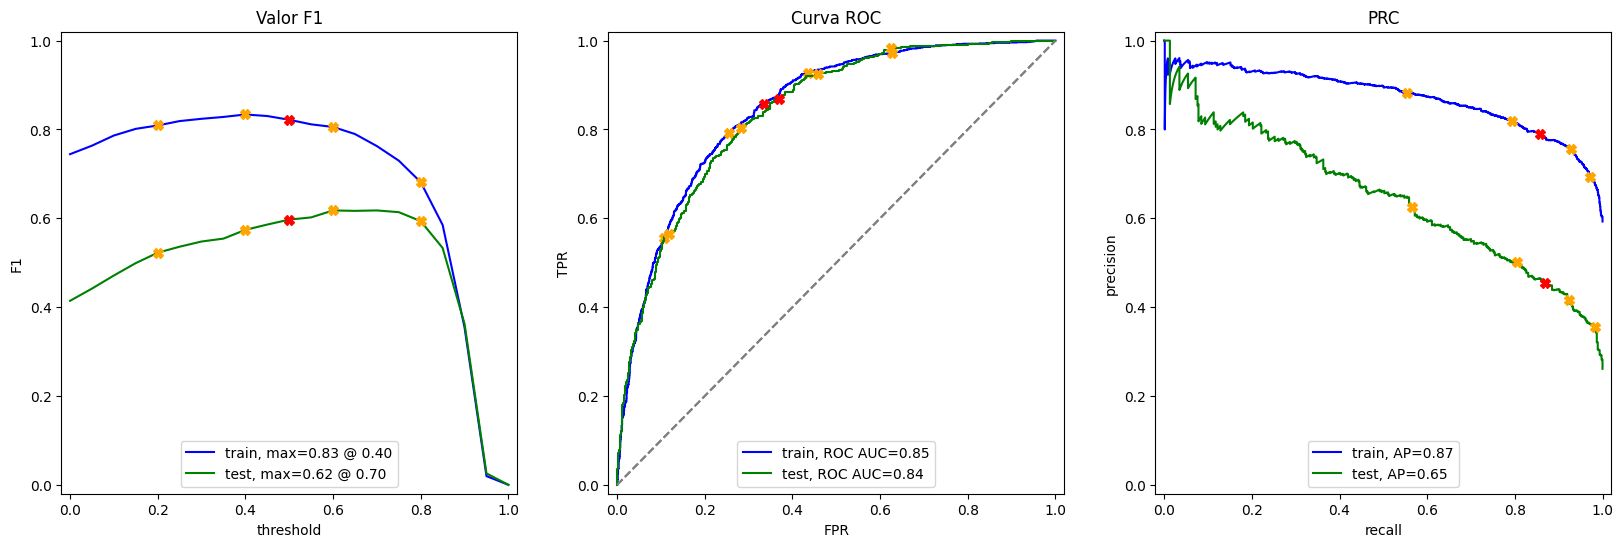

In [216]:
# Evaluación de modelo de regresión logística
evaluate_model(pipeline_lr, features_train_bal, target_train_bal, features_test, target_test)

El modelo demuestra tener resultados muy satisfactorios, sobre todo en la curva ROC, los valores de la prueba se asemejan mucho a los del entrenamiento. Esto refuerza la idea de que el modelo está aprendiendo de manera consistente. Falta comparar con los demás modelos para observar si pueden extraer de una mejor manera el comportamiento del dataset.  

#### Bosque aleatorio
Para este modelo, se utilizó las transformaciones como escalado y codificación, pero no se realizó el balanceo de la clase. El balanceo fue realizado por medio de los hiperparámetros del constructor del modelo.

In [217]:
# Modelo de Bosque aleatorio
# Escalador y codificador para uso en pipeline
preprocessor = ColumnTransformer(
    transformers=[("num", RobustScaler(), num_features), 
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

# Constructor, entrenamiento y predicción de valores por pipeline
pipeline_rf = Pipeline([('preprocess', preprocessor), 
                        ('model', RandomForestClassifier(
                            n_estimators=300,  
                            max_depth=10,
                            min_samples_split=20,
                            min_samples_leaf=10,
                            class_weight="balanced",
                            random_state=9732       
))])
pipeline_rf.fit(features_train, target_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalCharges', 'Meses']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Type', 'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'SeniorCitizen', 'Partner',
                                                   'Dependents',
                                                   'MultipleLines'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_leaf=10,
                                        min_samples_split=20, n_estimators=300,
                                        random_state=9732))])

            cv  train  test
Accuracy  0.79   0.82  0.78
F1        0.66   0.71  0.66
APS       0.71   0.79  0.71
ROC AUC   0.86   0.91  0.86


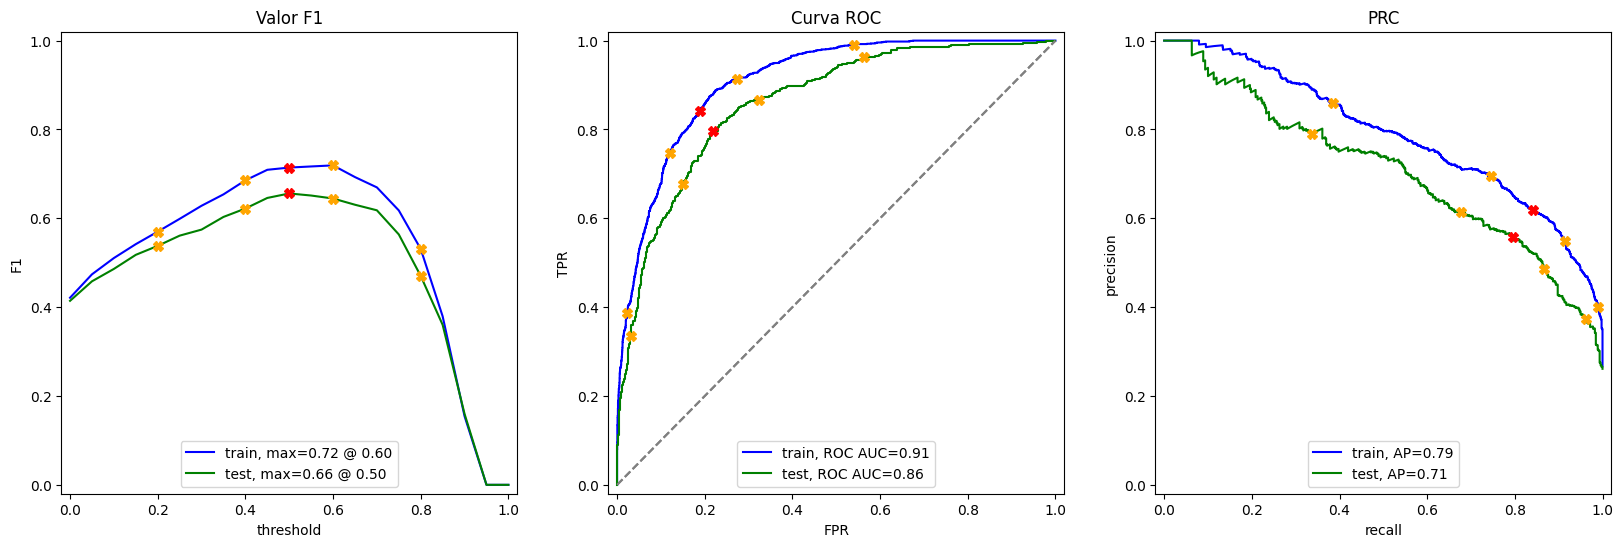

In [218]:
# Evaluación de bosque aleatorio
evaluate_model(pipeline_rf, features_train, target_train, features_test, target_test)

El modelo tuvo mejores resultados que la regresión logística, presenta un poco de sobreajuste en el entrenamiento. Sin embargo, en general se obtuvo una mejor puntuación en las métricas. Se alcanzó un ROC AUC de 0.86, aunque esta un poco sobreajustado aún asi se desempeña mejor.  

#### LightGBM
Para este modelo es necesario cambiar el tipo de datos de las características categóricas a **Category**, no se utiliza escalado de datos, codificación ni balanceo de clases.

In [ ]:
# Modelo de LightGBM
# Cambio de tipo de valor de datos categóricos y split de datos
features_train_lgb = features_train.copy()
features_test_lgb = features_test.copy()
for col in cat_features:
    features_train_lgb[col] = features_train_lgb[col].astype("category")
    features_test_lgb[col] = features_test_lgb[col].astype("category")
    

# Constructor y entrenamiento de LightGBM
model_lgbm = LGBMClassifier(
    objective='binary',
    boosting_type='goss',
    num_leaves=31,        
    max_depth=-1, 
    min_data_in_leaf=40, 
    lambda_l1=2,
    lambda_l2=2,
    n_estimators=1200, 
    learning_rate=0.008,
    metric="auc",
    random_state=9732,
    verbose=-1
    
)
model_lgbm.fit(features_train_lgb, target_train)

LGBMClassifier(boosting_type='goss', lambda_l1=2, lambda_l2=2,
               learning_rate=0.008, metric='auc', min_data_in_leaf=40,
               n_estimators=1200, objective='binary', random_state=9732,
               verbose=-1)

            cv  train  test
Accuracy  0.84   0.90  0.85
F1        0.67   0.80  0.70
APS       0.78   0.90  0.80
ROC AUC   0.88   0.94  0.89


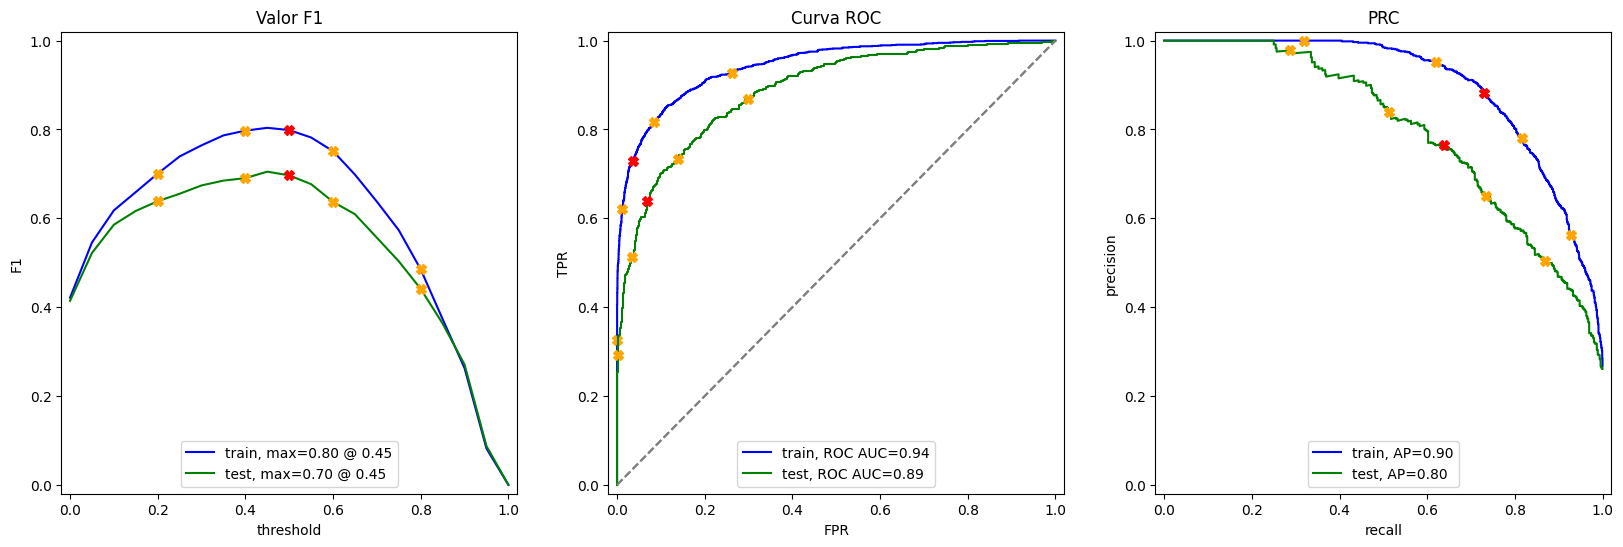

In [232]:
# Evaluación de LightGBM
evaluate_model(model_lgbm, features_train_lgb, target_train, features_test_lgb, target_test)

Para el modelo LightGBM, las métricas de desempeño son mucho mejores, no es tan consistente como el modelo de regresión logística pero si obtiene por mucho una mejor curva ROC.

#### CatBoost
Este último modelo no requiere modificaciones en los datos y se pasan a entrenamiento tal como se quedaron al modificarse en LightGBM para mantener consistencia en los métodos.

In [221]:
# Constructor y entrenamiento de CatBoost
model_cat = CatBoostClassifier(
    loss_function="Logloss",
    learning_rate=0.05,
    iterations=1200,
    depth=5,
    l2_leaf_reg=10,
    class_weights=[1, 1],          
    eval_metric="AUC",
    random_seed=9732,
    cat_features=cat_features,
    bootstrap_type="Bayesian",
    bagging_temperature=1,
    verbose=0      
)

model_cat.fit(features_train, target_train)

            cv  train  test
Accuracy  0.84   0.90  0.85
F1        0.67   0.79  0.68
APS       0.79   0.91  0.80
ROC AUC   0.89   0.95  0.89


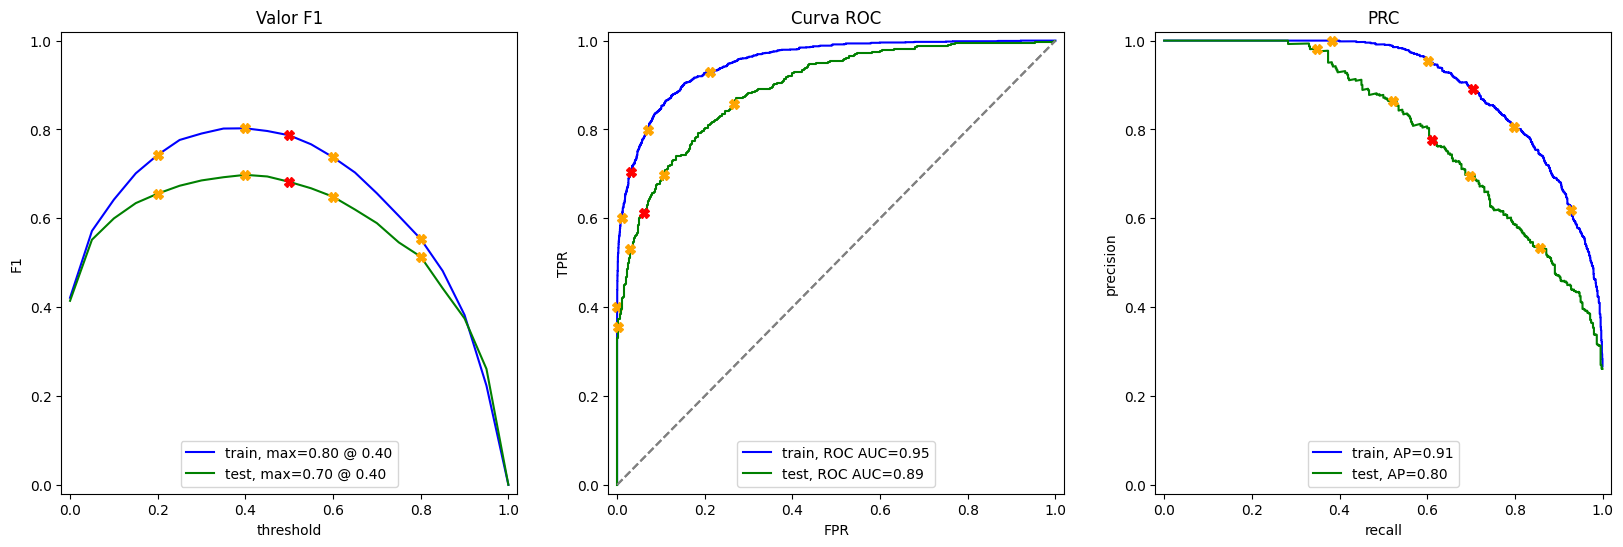

In [222]:
# Evaluación de CatBoost
evaluate_model(model_cat, features_train, target_train, features_test, target_test)

Nuestro último modelo ofrece resultados muy parecido a los del modelo LightGBM, con la grna diferencia de que el tiempo de computo para este modelo es un poco mayor.

### Conclusiones
Se utilizaron categorías que se consideraron relevantes para entrenar los diferentes modelos. Se necesitó hacer uso de ingeniería de características para mejorar el desempeño de los modelos. Los mejore modelos fueron LightGBM y CatBoost, el primero supera con un mejor tiempo de computo. Los resultados obtenidos de la regresión logística y el bosque aleatorio son aun asi bastante buenos con la ventaja de ser calculados con mayor velocidad. Usar LightGBM al preferir eficacia de calculo y usar bosque aleatorio en caso de requerir rapidez de computo.